In [190]:
from tqdm.auto import tqdm
from functools import partial
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path

import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.signal import savgol_filter
from scipy.optimize import minimize
from astropy.stats import sigma_clip

## Load data

In [2]:
DEBUG = False

DATA_ROOT = '../input/'
SPLIT = 'train'

In [56]:
nums_parallel = 48

In [ ]:
sensor_sizes_dict = {
    "AIRS-CH0": [[11250, 32, 356], [32, 356]],
    "FGS1": [[135000, 32, 32], [32, 32]],
}  # input, mask

cut_inf, cut_sup = 39, 321

In [4]:
adc_info = pd.read_csv(f'{DATA_ROOT}/{SPLIT}_adc_info.csv', index_col='planet_id')
print('Total num of examples:', adc_info.shape[0])

if DEBUG:
    adc_info = adc_info.head(32)
    print('DEBUG, only use 32 examples!')

Total num of examples: 673


In [5]:
axis_info = pd.read_parquet(f'{DATA_ROOT}/axis_info.parquet')

In [8]:
if SPLIT:
    label_df = pd.read_csv(f'{DATA_ROOT}/train_labels.csv', index_col='planet_id')

In [6]:
def read_signal_data(planet_id, sensor):
    ''' sensor: AIRS-CH0 or FGS1
    '''
    signal = pd.read_parquet(f'{DATA_ROOT}/{SPLIT}/{planet_id}/{sensor}_signal.parquet', engine='pyarrow')
    dark = pd.read_parquet(f'{DATA_ROOT}/{SPLIT}/{planet_id}/{sensor}_calibration/dark.parquet', engine='pyarrow')
    dead = pd.read_parquet(f'{DATA_ROOT}/{SPLIT}/{planet_id}/{sensor}_calibration/dead.parquet', engine='pyarrow')
    flat = pd.read_parquet(f'{DATA_ROOT}/{SPLIT}/{planet_id}/{sensor}_calibration/flat.parquet', engine='pyarrow')
    linear_corr = pd.read_parquet(f'{DATA_ROOT}/{SPLIT}/{planet_id}/{sensor}_calibration/linear_corr.parquet', engine='pyarrow')
    read = pd.read_parquet(f'{DATA_ROOT}/{SPLIT}/{planet_id}/{sensor}_calibration/read.parquet', engine='pyarrow')

    # reshape
    signal = signal.values.reshape(sensor_sizes_dict[sensor][0]).astype(np.float64)
    dark = dark.values.reshape(sensor_sizes_dict[sensor][1]).astype(np.float64)
    dead = dead.values.reshape(sensor_sizes_dict[sensor][1])  # bool
    flat = flat.values.reshape(sensor_sizes_dict[sensor][1]).astype(np.float64)
    linear_corr = linear_corr.values.reshape([6] + sensor_sizes_dict[sensor][1]).astype(np.float64)
    read = read.values.reshape(sensor_sizes_dict[sensor][1]).astype(np.float64)
    
    return signal, dark, dead, flat, linear_corr, read

## Calibration

In [303]:
def ADC_convert(signal, gain, offset):
    signal /= gain
    signal += offset
    return signal

def get_gain_offset(planet_id, sensor):
    gain = adc_info.loc[planet_id][f'{sensor}_adc_gain']
    offset = adc_info.loc[planet_id][f'{sensor}_adc_offset']
    return gain, offset

def mask_hot_dead(signal, dead, dark):
    hot = sigma_clip(dark, sigma=5, maxiters=5).mask
    hot = np.tile(hot, (signal.shape[0], 1, 1))
    dead = np.tile(dead, (signal.shape[0], 1, 1))

    # Set values to np.nan where dead or hot pixels are found
    signal[dead] = np.nan
    signal[hot] = np.nan
    return signal

def apply_linear_corr(c, signal):
    assert c.shape[0] == 6  # Ensure the polynomial is of degree 5
    return (
        (((c[5] * signal + c[4]) * signal + c[3]) * signal + c[2]) * signal + c[1]
    ) * signal + c[0]

def clean_dark(signal, dark, dt):
    dark = np.tile(dark, (signal.shape[0], 1, 1))
    signal -= dark * dt[:, np.newaxis, np.newaxis]
    return signal

def get_cds(signal):
    cds = signal[1::2, :, :] - signal[::2, :, :]
    return cds

def correct_flat_field(flat, signal):
    return signal / flat

def preprocess_signal_data(planet_id, reduction=True):
    
    dt_airs = axis_info["AIRS-CH0-integration_time"].dropna().values
    dt_fgs1 = np.ones(sensor_sizes_dict['FGS1'][0][0]) * 0.1
    
    res = []
    for sensor in ["FGS1", "AIRS-CH0"]:
        signal, dark, dead, flat, linear_corr, read = read_signal_data(planet_id, sensor)
        
        # step1: ADC
        gain, offset = get_gain_offset(planet_id, sensor)
        signal = ADC_convert(signal, gain, offset)
        
        # step2: Mask hot/dead pixel
        signal = mask_hot_dead(signal, dead, dark)
        
        # step3: linearity Correction
        signal = apply_linear_corr(linear_corr, signal)
        
        # step4: dark current subtraction
        dt = dt_airs if sensor == 'AIRS-CH0' else dt_fgs1
        dt[1::2] += 0.1
        signal = clean_dark(signal, dark, dt)
        
        # step5: CDS
        signal = get_cds(signal)
        
        # step6: Flat Field Correction
        signal = correct_flat_field(flat, signal)

        # step7: Mean reduction
        if reduction:
            if sensor == 'AIRS-CH0':
                signal = np.nanmean(signal, axis=1).astype(np.float32)  # T x 356
            else:
                signal = np.nanmean(signal, axis=(1, 2)).astype(np.float32) 
        
        res.append(signal)
    
    return res  # FGS1, AIRS-CH0

## Feature Engineering

### Transit Zone

In [212]:
def smooth_data(data, window_size):
    return savgol_filter(data, window_size, 3)  # window size 51, polynomial order 3


def optimize_breakpoint(data, initial_breakpoint, window_size=500, buffer_size=50, smooth_window=121):
    best_breakpoint = initial_breakpoint
    best_score = float("-inf")
    midpoint = len(data) // 2
    smoothed_data = smooth_data(data, smooth_window)

    for i in range(-window_size, window_size):
        new_breakpoint = initial_breakpoint + i
        region1 = data[: new_breakpoint - buffer_size]
        region2 = data[
            new_breakpoint
            + buffer_size : len(data)
            - new_breakpoint
            - buffer_size
        ]
        region3 = data[len(data) - new_breakpoint + buffer_size :]

        # calc on smoothed data
        breakpoint_region1 = smoothed_data[new_breakpoint - buffer_size: new_breakpoint + buffer_size]
        breakpoint_region2 = smoothed_data[-(new_breakpoint + buffer_size): -(new_breakpoint - buffer_size)]

        mean_diff = abs(np.mean(region1) - np.mean(region2)) + abs(
            np.mean(region2) - np.mean(region3)
        )
        var_sum = np.var(region1) + np.var(region2) + np.var(region3)
        range_at_breakpoint1 = (np.max(breakpoint_region1) - np.min(breakpoint_region1))
        range_at_breakpoint2 = (np.max(breakpoint_region2) - np.min(breakpoint_region2))

        mean_range_at_breakpoint = (range_at_breakpoint1 + range_at_breakpoint2) / 2

        score = mean_diff - 0.5 * var_sum + mean_range_at_breakpoint

        if score > best_score:
            best_score = score
            best_breakpoint = new_breakpoint

    return best_breakpoint


FGS1_BUFFER_SIZE = 1500
AIRS_BUFFER_SIZE = 120

def find_breakpoints(f_raw, a_raw):
    res = {}
    for sensor_name in ["AIRS-CH0", "FGS1"]:
        if sensor_name == "AIRS-CH0":
            buffer_size = 120
            smooth_window = 121
            window_size = 500
            default_breakpoint = 1821
            data = a_raw
        elif sensor_name == "FGS1":
            buffer_size = 1500
            smooth_window = 1001
            window_size = 3500
            default_breakpoint = 21500
            data = f_raw

        initial_breakpoint = default_breakpoint

        optimized_breakpoint = optimize_breakpoint(
            data,
            initial_breakpoint,
            window_size=window_size,
            buffer_size=buffer_size,
            smooth_window=smooth_window,
        )

        midpoint = len(data) // 2
        breakpoints = [optimized_breakpoint, 2 * midpoint - optimized_breakpoint]

        res[sensor_name] = breakpoints
        
    return res


def find_and_plot_breakpoints(f_raw, a_raw, verbose=False):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    for sensor_name in ["AIRS-CH0", "FGS1"]:
        if sensor_name == "AIRS-CH0":
            buffer_size = 120
            smooth_window = 121
            window_size = 500
            default_breakpoint = 1821
            data = a_raw
        elif sensor_name == "FGS1":
            buffer_size = 1500
            smooth_window = 1001
            window_size = 3500
            default_breakpoint = 21500
            data = f_raw

        initial_breakpoint = default_breakpoint

        if verbose:
            print(f"Initial breakpoint: {initial_breakpoint}")
        optimized_breakpoint = optimize_breakpoint(
            data,
            initial_breakpoint,
            window_size=window_size,
            buffer_size=buffer_size,
            smooth_window=smooth_window,
        )

        midpoint = len(data) // 2
        breakpoints = [optimized_breakpoint, 2 * midpoint - optimized_breakpoint]

        if sensor_name == "FGS1":
            ax = ax2
        elif sensor_name == "AIRS-CH0":
            ax = ax1

        # Plot the results
        ax.plot(data, color='#4E79A7', alpha=0.7, label="Original Data")
        ax.plot(smooth_data(data, smooth_window), label="Smoothed Data", color='#F28E2B')

        for bp in breakpoints:
            ax.axvline(x=bp - buffer_size, color="r", linestyle="--")
            ax.axvline(x=bp + buffer_size, color="r", linestyle="--")
            ax.axvspan(bp - buffer_size, bp + buffer_size, color="gray", alpha=0.3)

        ax.set_title(f"{sensor_name}")
        ax.set_xlabel("Time step")
        ax.set_ylabel("Value")
        ax.legend()
    fig.tight_layout()
    plt.show()

In [10]:
planet_id = 785834
sensor = 'AIRS-CH0'
# sensor = 'FGS1'

In [11]:
fgs1_signal, airs_signal = preprocess_signal_data(planet_id)

In [12]:
fgs1_signal.shape, airs_signal.shape

((67500,), (5625, 356))

In [36]:
f_raw = fgs1_signal
a_raw = airs_signal.mean(axis=-1)

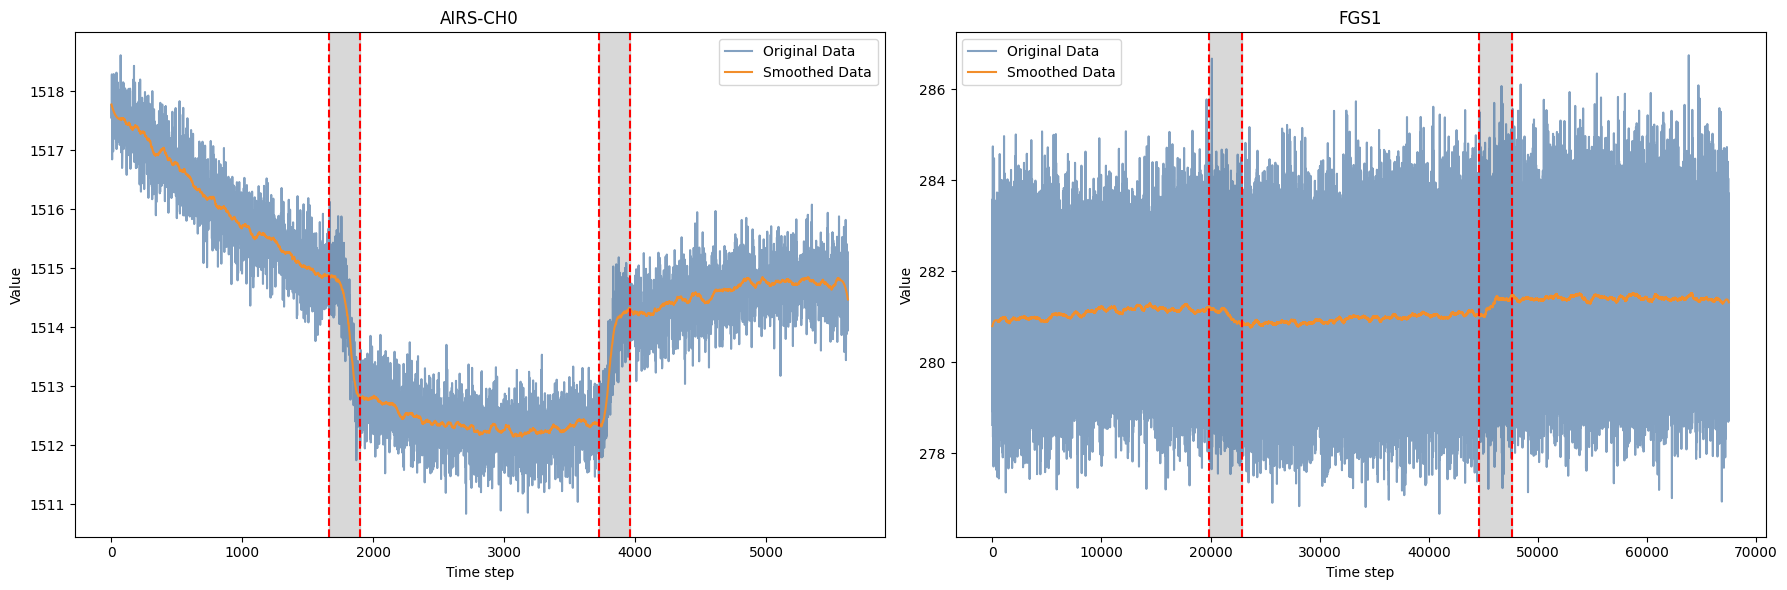

In [81]:
find_and_plot_breakpoints(f_raw, a_raw)

In [53]:
%%time
breakpoints = find_breakpoints(f_raw, a_raw)

CPU times: user 2.61 s, sys: 4.65 ms, total: 2.61 s
Wall time: 2.61 s


In [47]:
breakpoints

{'AIRS-CH0': [1781, 3843], 'FGS1': [21374, 46126]}

In [49]:
train_processed_data = np.load('train_processed.npz')

In [50]:
f_raw_train = train_processed_data['f_raw_train']
a_raw_train = train_processed_data['a_raw_train']

In [305]:
a_raw_train_mean = a_raw_train[:, :, cut_inf:cut_sup].mean(axis=-1)

In [306]:
f_raw_train.shape, a_raw_train.shape, a_raw_train_mean.shape

((673, 67500), (673, 5625, 356), (673, 5625))

In [60]:
with ProcessPoolExecutor(nums_parallel) as exe:
    breakpoints = list( tqdm(exe.map(find_breakpoints, f_raw_train, a_raw_train_mean), total=f_raw_train.shape[0]) )

  0%|          | 0/673 [00:00<?, ?it/s]

In [68]:
adc_info['breakpoints'] = breakpoints

In [70]:
adc_info['r0'] = adc_info.breakpoints.apply(lambda dct: dct['FGS1'][0] / dct['AIRS-CH0'][0])
adc_info['r1'] = adc_info.breakpoints.apply(lambda dct: dct['FGS1'][1] / dct['AIRS-CH0'][1])

<Axes: ylabel='Frequency'>

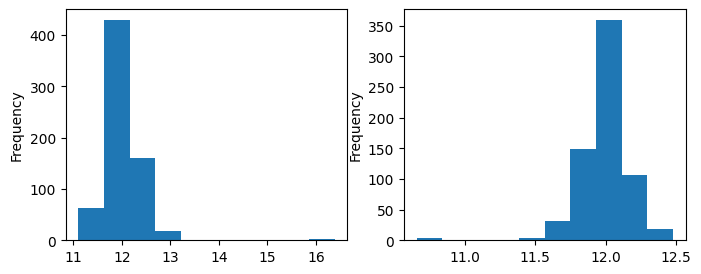

In [79]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
adc_info.r0.plot(kind='hist')

plt.subplot(1, 2, 2)
adc_info.r1.plot(kind='hist')

In [71]:
adc_info.head()

,FGS1_adc_offset,FGS1_adc_gain,AIRS-CH0_adc_offset,AIRS-CH0_adc_gain,star,breakpoints,r0,r1
planet_id,,,,,,,,
785834,-343.335938,0.837244,-778.916533,0.924746,1,"{'AIRS-CH0': [1779, 3845], 'FGS1': [21374, 461...",12.014615,11.996359
14485303,-366.381992,0.842983,-740.323212,0.931727,1,"{'AIRS-CH0': [1786, 3838], 'FGS1': [22167, 453...",12.411534,11.811621
17002355,-386.107037,1.041701,-808.690659,1.513541,0,"{'AIRS-CH0': [1807, 3817], 'FGS1': [21432, 460...",11.860542,12.069164
24135240,-339.737490,0.840239,-776.124167,0.931277,1,"{'AIRS-CH0': [1810, 3814], 'FGS1': [22486, 450...",12.423204,11.802307
25070640,-355.660433,1.041280,-848.371494,1.503923,0,"{'AIRS-CH0': [1964, 3660], 'FGS1': [23835, 436...",12.135947,11.930328


## Modeling

### Zero Model

直接计算`transit depth`

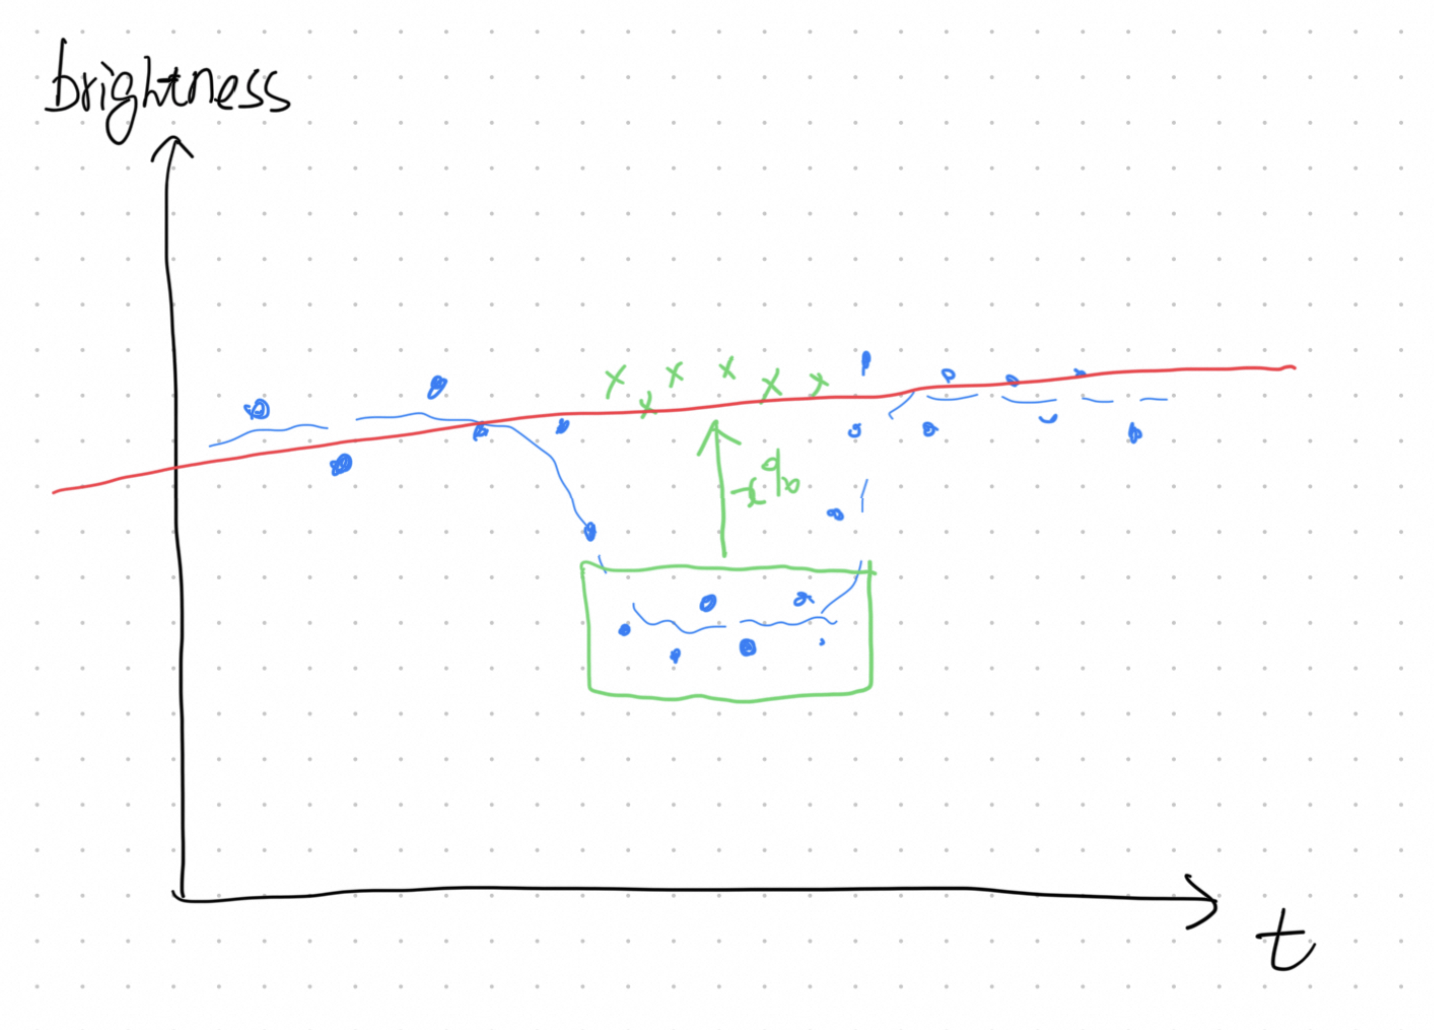

In [213]:
def try_s(sensor, signal, p1, p2, deg, s):
    buffer_size = AIRS_BUFFER_SIZE if sensor == 'AIRS-CH0' else FGS1_BUFFER_SIZE

    out1_start, out1_end = 0, p1 - buffer_size
    in_start, in_end = p1 + buffer_size, p2 - buffer_size
    out2_start, out2_end = p2 + buffer_size, signal.shape[0]
    
    out = list(range(out1_start, out1_end)) + list(range(out2_start, out2_end))
    x, y = out, signal[out].tolist()
    x = x + list(range(in_start, in_end))
    y = y + (signal[in_start:in_end] * (1 + s[0])).tolist()
    
    z = np.polyfit(x, y, deg)
    p = np.poly1d(z)
    q = np.abs(p(x) - y).mean()

    if s < 1e-4:
        return q + 1e3

    return q


def fit_transit_depth(sensor, signal, breakpoints):
    p1, p2 = breakpoints
    
    buffer_size = AIRS_BUFFER_SIZE if sensor == 'AIRS-CH0' else FGS1_BUFFER_SIZE
    out1_start, out1_end = 0, p1 - buffer_size
    in_start, in_end = p1 + buffer_size, p2 - buffer_size
    out2_start, out2_end = p2 + buffer_size, signal.shape[0]
    
    best_deg, best_score = 1, 1e12
    best_s = None
    for deg in range(1, 6):
        f = partial(try_s, sensor, signal, p1, p2, deg)
        r = minimize(f, [0.001], method = 'Nelder-Mead')
        s = r.x[0]

        out = list(range(out1_start, out1_end)) + list(range(out2_start, out2_end))
        x, y = out, signal[out].tolist()
        x = x + list(range(in_start, in_end))
        y = y + (signal[in_start:in_end] * (1 + s)).tolist()
    
        z = np.polyfit(x, y, deg)
        p = np.poly1d(z)
        q = np.abs(p(x) - y).mean()
        
        if q < best_score:
            best_score = q
            best_deg = deg
            best_s = s

        # print(deg, q, s)
        
    z = np.polyfit(x, y, best_deg)
    p = np.poly1d(z)
    
    return best_s, p(np.arange(signal.shape[0]))

#### 预测均值作为所有波长 `transit depth` 的估计

##### AIRS-CH0

In [307]:
i = 2
a_raw = a_raw_train_mean[i]
info = adc_info.iloc[i]
label = label_df.iloc[i]

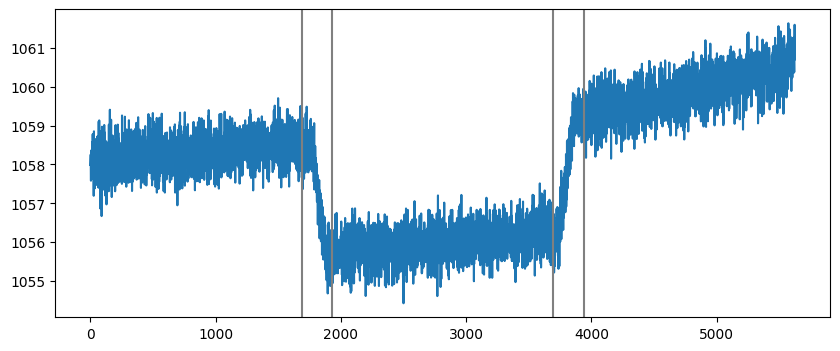

In [309]:
plt.figure(figsize=(10, 4))
plt.plot(a_raw)
for bp in info.breakpoints['AIRS-CH0']:
    plt.axvline(bp - AIRS_BUFFER_SIZE, color='gray')
    plt.axvline(bp + AIRS_BUFFER_SIZE, color='gray')

In [310]:
sensor = 'AIRS-CH0'
depth, fit_a_raw = fit_transit_depth(sensor, a_raw, info.breakpoints[sensor])

In [311]:
depth

0.0027000000000000058

In [313]:
label.values[1:].mean(), label.values[1:].min(), label.values[1:].max()

(0.0028009388098960593, 0.0027833107096022, 0.0028382939855995)

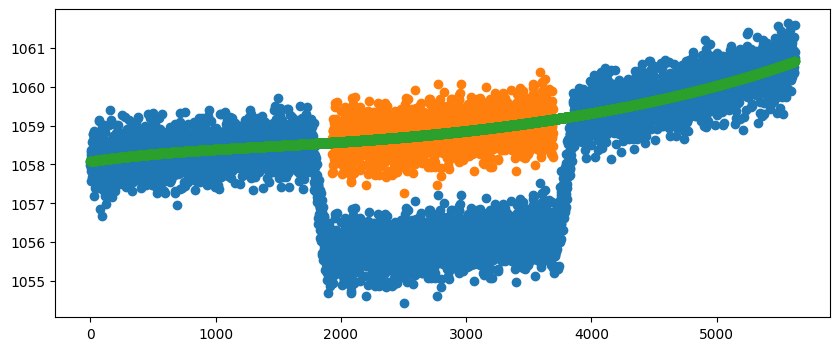

In [314]:
plt.figure(figsize=(10, 4))
x = np.arange(a_raw.shape[0])
plt.scatter(x, a_raw)

p1, p2 = info.breakpoints['AIRS-CH0']
idx1 = p1 + AIRS_BUFFER_SIZE
idx2 = p2 - AIRS_BUFFER_SIZE
plt.scatter(x[idx1:idx2], a_raw[idx1:idx2] * (1 + depth))

plt.scatter(x, fit_a_raw)

##### FGS1

In [315]:
sensor = 'FGS1'

In [316]:
i = 2
f_raw = f_raw_train[i]
info = adc_info.iloc[i]
label = label_df.iloc[i]

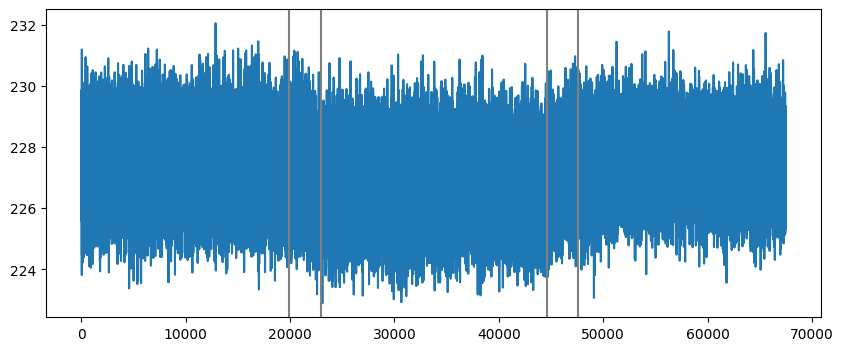

In [317]:
plt.figure(figsize=(10, 4))
plt.plot(f_raw)
for bp in info.breakpoints[sensor]:
    plt.axvline(bp - FGS1_BUFFER_SIZE, color='gray')
    plt.axvline(bp + FGS1_BUFFER_SIZE, color='gray')

In [318]:
depth, fit_f_raw = fit_transit_depth(sensor, f_raw, info.breakpoints[sensor])

In [319]:
depth

0.002850000000000006

In [320]:
label.values[0]

0.0027918368327131

##### 计算指标

In [344]:
import scipy

In [329]:
from sklearn.metrics import r2_score, mean_squared_error

In [340]:
wavelengths = pd.read_csv(f'{DATA_ROOT}/wavelengths.csv')

In [330]:
def postprocessing(pred_array, index, sigma_pred):
    """Create a submission dataframe from its components
    
    Parameters:
    pred_array: ndarray of shape (n_samples, 283)
    index: pandas.Index of length n_samples with name 'planet_id'
    sigma_pred: float
    
    Return value:
    df: DataFrame of shape (n_samples, 566) with planet_id as index
    """
    return pd.concat([pd.DataFrame(pred_array.clip(0, None), index=index, columns=wavelengths.columns),
                      pd.DataFrame(sigma_pred, index=index, columns=[f"sigma_{i}" for i in range(1, 284)])],
                     axis=1)

# Adapted from https://www.kaggle.com/code/metric/ariel-gaussian-log-likelihood
class ParticipantVisibleError(Exception):
    pass

def competition_score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        naive_mean: float,
        naive_sigma: float,
        sigma_true: float,
        row_id_column_name='planet_id',
    ) -> float:
    '''
    This is a Gaussian Log Likelihood based metric. For a submission, which contains the predicted mean (x_hat) and variance (x_hat_std),
    we calculate the Gaussian Log-likelihood (GLL) value to the provided ground truth (x). We treat each pair of x_hat,
    x_hat_std as a 1D gaussian, meaning there will be 283 1D gaussian distributions, hence 283 values for each test spectrum,
    the GLL value for one spectrum is the sum of all of them.

    Inputs:
        - solution: Ground Truth spectra (from test set)
            - shape: (nsamples, n_wavelengths)
        - submission: Predicted spectra and errors (from participants)
            - shape: (nsamples, n_wavelengths*2)
        naive_mean: (float) mean from the train set.
        naive_sigma: (float) standard deviation from the train set.
        sigma_true: (float) essentially sets the scale of the outputs.
    '''

    del solution[row_id_column_name]
    del submission[row_id_column_name]

    if submission.min().min() < 0:
        raise ParticipantVisibleError('Negative values in the submission')
    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')

    n_wavelengths = len(solution.columns)
    if len(submission.columns) != n_wavelengths*2:
        raise ParticipantVisibleError('Wrong number of columns in the submission')

    y_pred = submission.iloc[:, :n_wavelengths].values
    # Set a non-zero minimum sigma pred to prevent division by zero errors.
    sigma_pred = np.clip(submission.iloc[:, n_wavelengths:].values, a_min=10**-15, a_max=None)
    y_true = solution.values

    GLL_pred = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_pred, scale=sigma_pred))
    GLL_true = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_true, scale=sigma_true * np.ones_like(y_true)))
    GLL_mean = np.sum(scipy.stats.norm.logpdf(y_true, loc=naive_mean * np.ones_like(y_true), scale=naive_sigma * np.ones_like(y_true)))

    submit_score = (GLL_pred - GLL_mean)/(GLL_true - GLL_mean)
    return float(np.clip(submit_score, 0.0, 1.0))

In [321]:
def fit_task(f_raw, a_raw, breakpoints):
    f_depth, _ = fit_transit_depth('FGS1', f_raw, breakpoints['FGS1'])
    a_depth, _ = fit_transit_depth('AIRS-CH0', a_raw, breakpoints['AIRS-CH0'])
    return f_depth, a_depth

In [322]:
i = 0
f_raw = f_raw_train[i]
a_raw = a_raw_train_mean[i]
breakpoints = adc_info.breakpoints.iloc[i]

In [323]:
%%time
f_depth, a_depth = fit_task(f_raw, a_raw, breakpoints)

CPU times: user 772 ms, sys: 230 ms, total: 1 s
Wall time: 788 ms


In [324]:
f_depth, a_depth

(0.001, 0.0011000000000000003)

In [326]:
with ProcessPoolExecutor(nums_parallel) as exe:
    all_depth = list( tqdm(exe.map(fit_task, f_raw_train, a_raw_train_mean, adc_info.breakpoints), total=adc_info.shape[0]) )

  0%|          | 0/673 [00:00<?, ?it/s]

In [327]:
adc_info['all_depth'] = all_depth
adc_info['f_depth'] = adc_info.all_depth.apply(lambda x: x[0])
adc_info['a_depth'] = adc_info.all_depth.apply(lambda x: x[1])
adc_info.f_depth = adc_info.f_depth.clip(0)
adc_info.a_depth = adc_info.a_depth.clip(0)

In [332]:
train_sigma = 0.000176

In [348]:
adc_info['pred'] = adc_info.apply(
    # lambda r: [r.f_depth] + [r.a_depth] * 282 + [train_sigma] * 283,
    lambda r: [r.a_depth] + [r.a_depth] * 282 + [train_sigma] * 283,
    axis=1,
)

In [349]:
oof_pred = np.array(adc_info.pred.tolist(), dtype=np.float32)
oof_pred.shape

(673, 566)

In [350]:
r2_score(label_df.values[:, :283], oof_pred[:, :283])

0.9957135802073479

In [351]:
sigma_pred = mean_squared_error(label_df.values[:, :283], oof_pred[:, :283], squared=False)

In [352]:
sigma_pred

0.00010580869676682208

In [353]:
oof_df = postprocessing(oof_pred[:, :283], adc_info.index, train_sigma)

In [354]:
gll_score = competition_score(label_df.reset_index(),
                              oof_df.reset_index(),
                              naive_mean=label_df.values.mean(),
                              naive_sigma=label_df.values.std(),
                              sigma_true=0.000003)
print(f"# Estimated competition score: {gll_score:.3f}")

# Estimated competition score: 0.376


#### 为每个波长预测 `transit depth`

In [369]:
i = 1
a_raw = a_raw_train[i]
info = adc_info.iloc[i]
label = label_df.iloc[i]

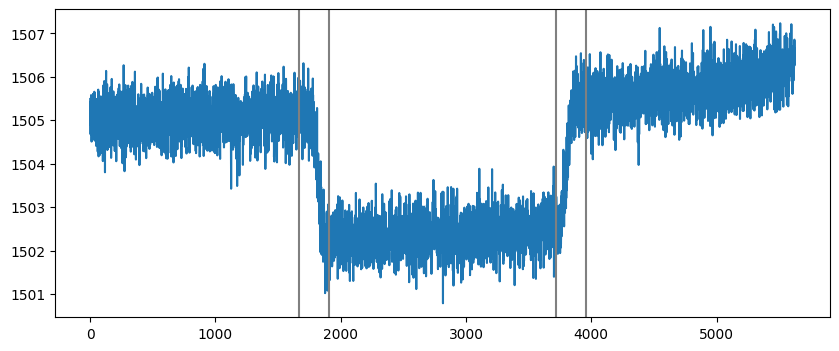

In [370]:
plt.figure(figsize=(10, 4))
plt.plot(a_raw.mean(axis=-1))
for bp in info.breakpoints['AIRS-CH0']:
    plt.axvline(bp - AIRS_BUFFER_SIZE, color='gray')
    plt.axvline(bp + AIRS_BUFFER_SIZE, color='gray')

In [371]:
sensor = 'AIRS-CH0'

In [372]:
all_depth = []
for i in tqdm(range(cut_inf, cut_sup)):
    wv_raw = a_raw[:, i]
    depth, _ = fit_transit_depth(sensor, wv_raw, info.breakpoints['AIRS-CH0'])
    all_depth.append(depth)

  0%|          | 0/282 [00:00<?, ?it/s]

In [373]:
all_depth = np.array(all_depth, dtype=np.float32)

In [374]:
all_depth = all_depth[::-1]

In [375]:
all_depth.mean()

0.0015029256

In [376]:
mean_depth, _ = fit_transit_depth('AIRS-CH0', a_raw[:, cut_inf:cut_sup].mean(axis=-1), info.breakpoints['AIRS-CH0'])

In [377]:
mean_depth

0.0019500000000000032

In [378]:
label.mean()

0.001902150103421778

In [383]:
smoothed_all_depth = savgol_filter(all_depth, 5, 3)

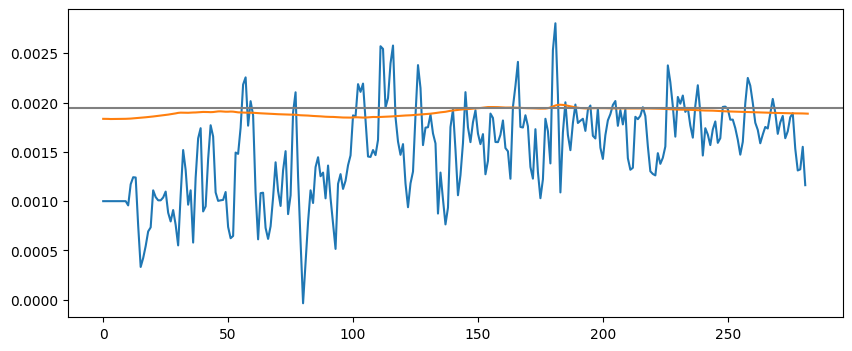

In [384]:
plt.figure(figsize=(10, 4))
plt.plot(smoothed_all_depth[::-1])
plt.plot(label.values)
plt.axhline(mean_depth, color='gray')

噪声太大，直接计算不可行